In [1]:
import warnings
warnings.filterwarnings('ignore')


#Important libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Reading and Cleaning Data

In [2]:
df = pd.read_csv(r"G:\PGDDS\Notes\ML Module 6 Assign\Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df.shape


(167, 10)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
df.isnull().sum()


country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

#### We can see there are no null values.


Some columns need to be converted to normal values


In [7]:
df['exports'] = (df['exports']*df['gdpp'])/100

df['health'] = (df['health']*df['gdpp'])/100

df['imports'] = (df['imports']*df['gdpp'])/100

In [8]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### EDA

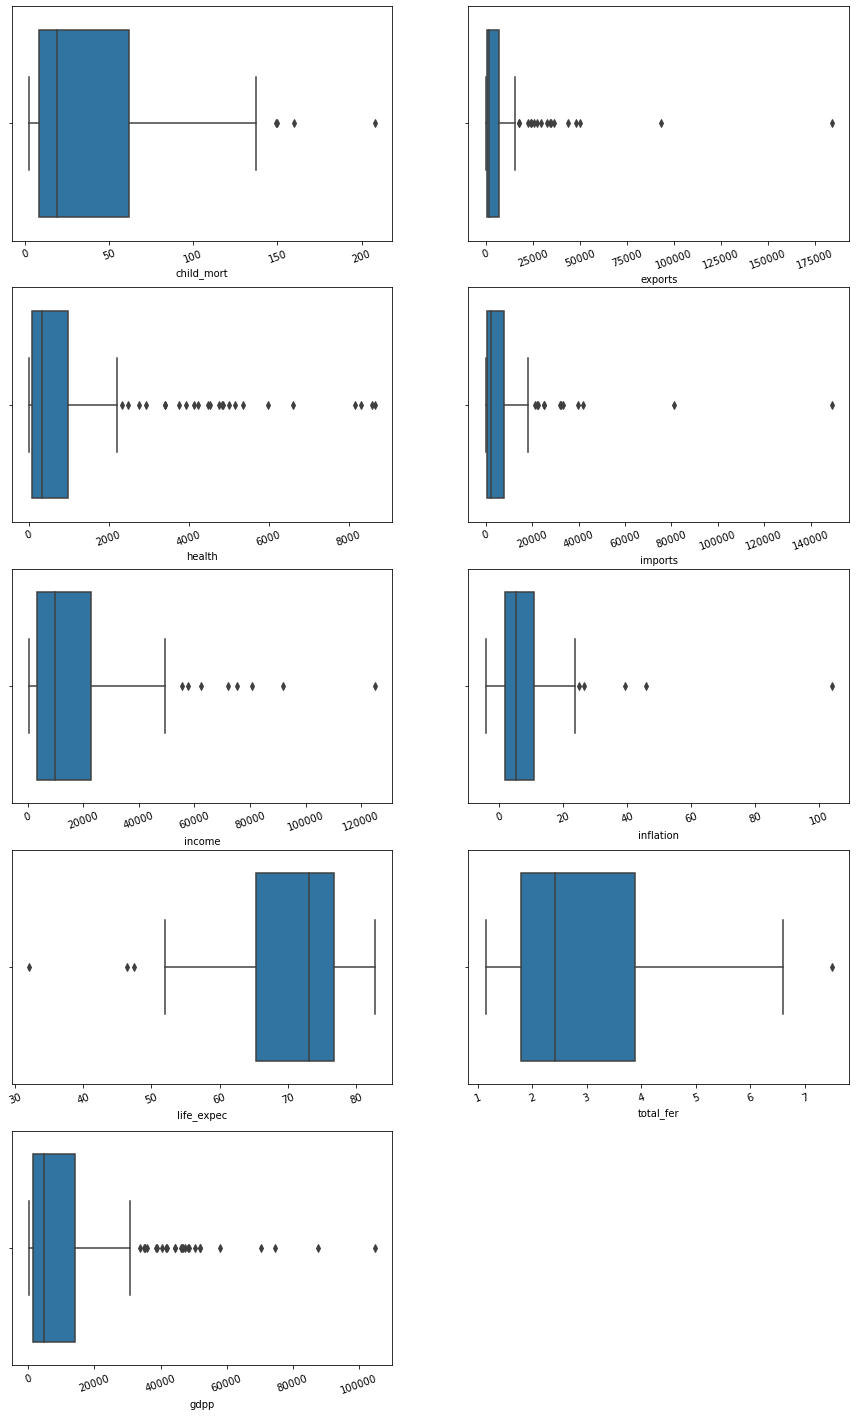

In [13]:
plt.figure(figsize=(15,25))
features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)

We can see there are outliers in every column

### Outliers Treatment

In [14]:
def outlier_treatment(df, col):
    
    Q1 = df[col].quantile(0.25)

    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_cap  = Q1-1.5*IQR

    higher_cap = Q3+1.5*IQR

    df.loc[(df[col] > higher_cap), col] = higher_cap
    df.loc[(df[col] < lower_cap), col] = lower_cap
    
    return df

In [15]:
df = outlier_treatment(df, 'child_mort')
df = outlier_treatment(df, 'exports')
df = outlier_treatment(df, 'health')
df = outlier_treatment(df, 'imports')
df = outlier_treatment(df, 'income')
df = outlier_treatment(df, 'inflation')
df = outlier_treatment(df, 'life_expec')
df = outlier_treatment(df, 'total_fer')
df = outlier_treatment(df, 'gdpp')

In [16]:
df.describe()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,37.698204,4710.954895,680.241240,4756.898995,15921.574850,7.065066,70.663772,2.945075,10351.281437
std,38.443293,5832.960967,804.768458,5690.687520,15207.197459,6.704968,8.522535,1.505564,11612.044330
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,48.050000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,142.875000,17524.290000,2324.546750,18338.677500,51967.500000,24.160000,82.800000,7.007500,33130.000000


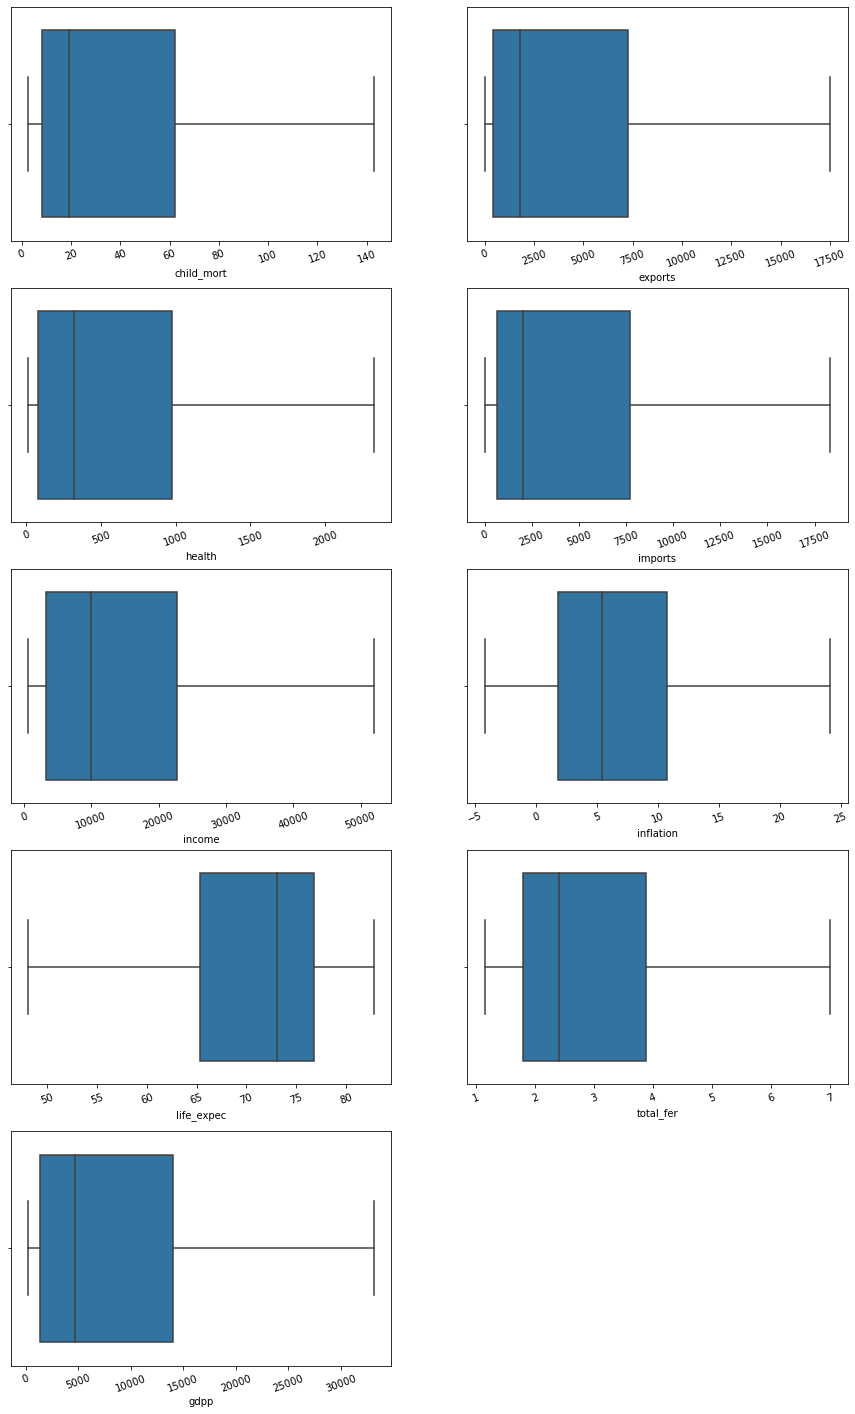

In [17]:
plt.figure(figsize=(15,25))
features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
for i in enumerate(features): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation = 20)

We treated ouliers by upper and lower capping them

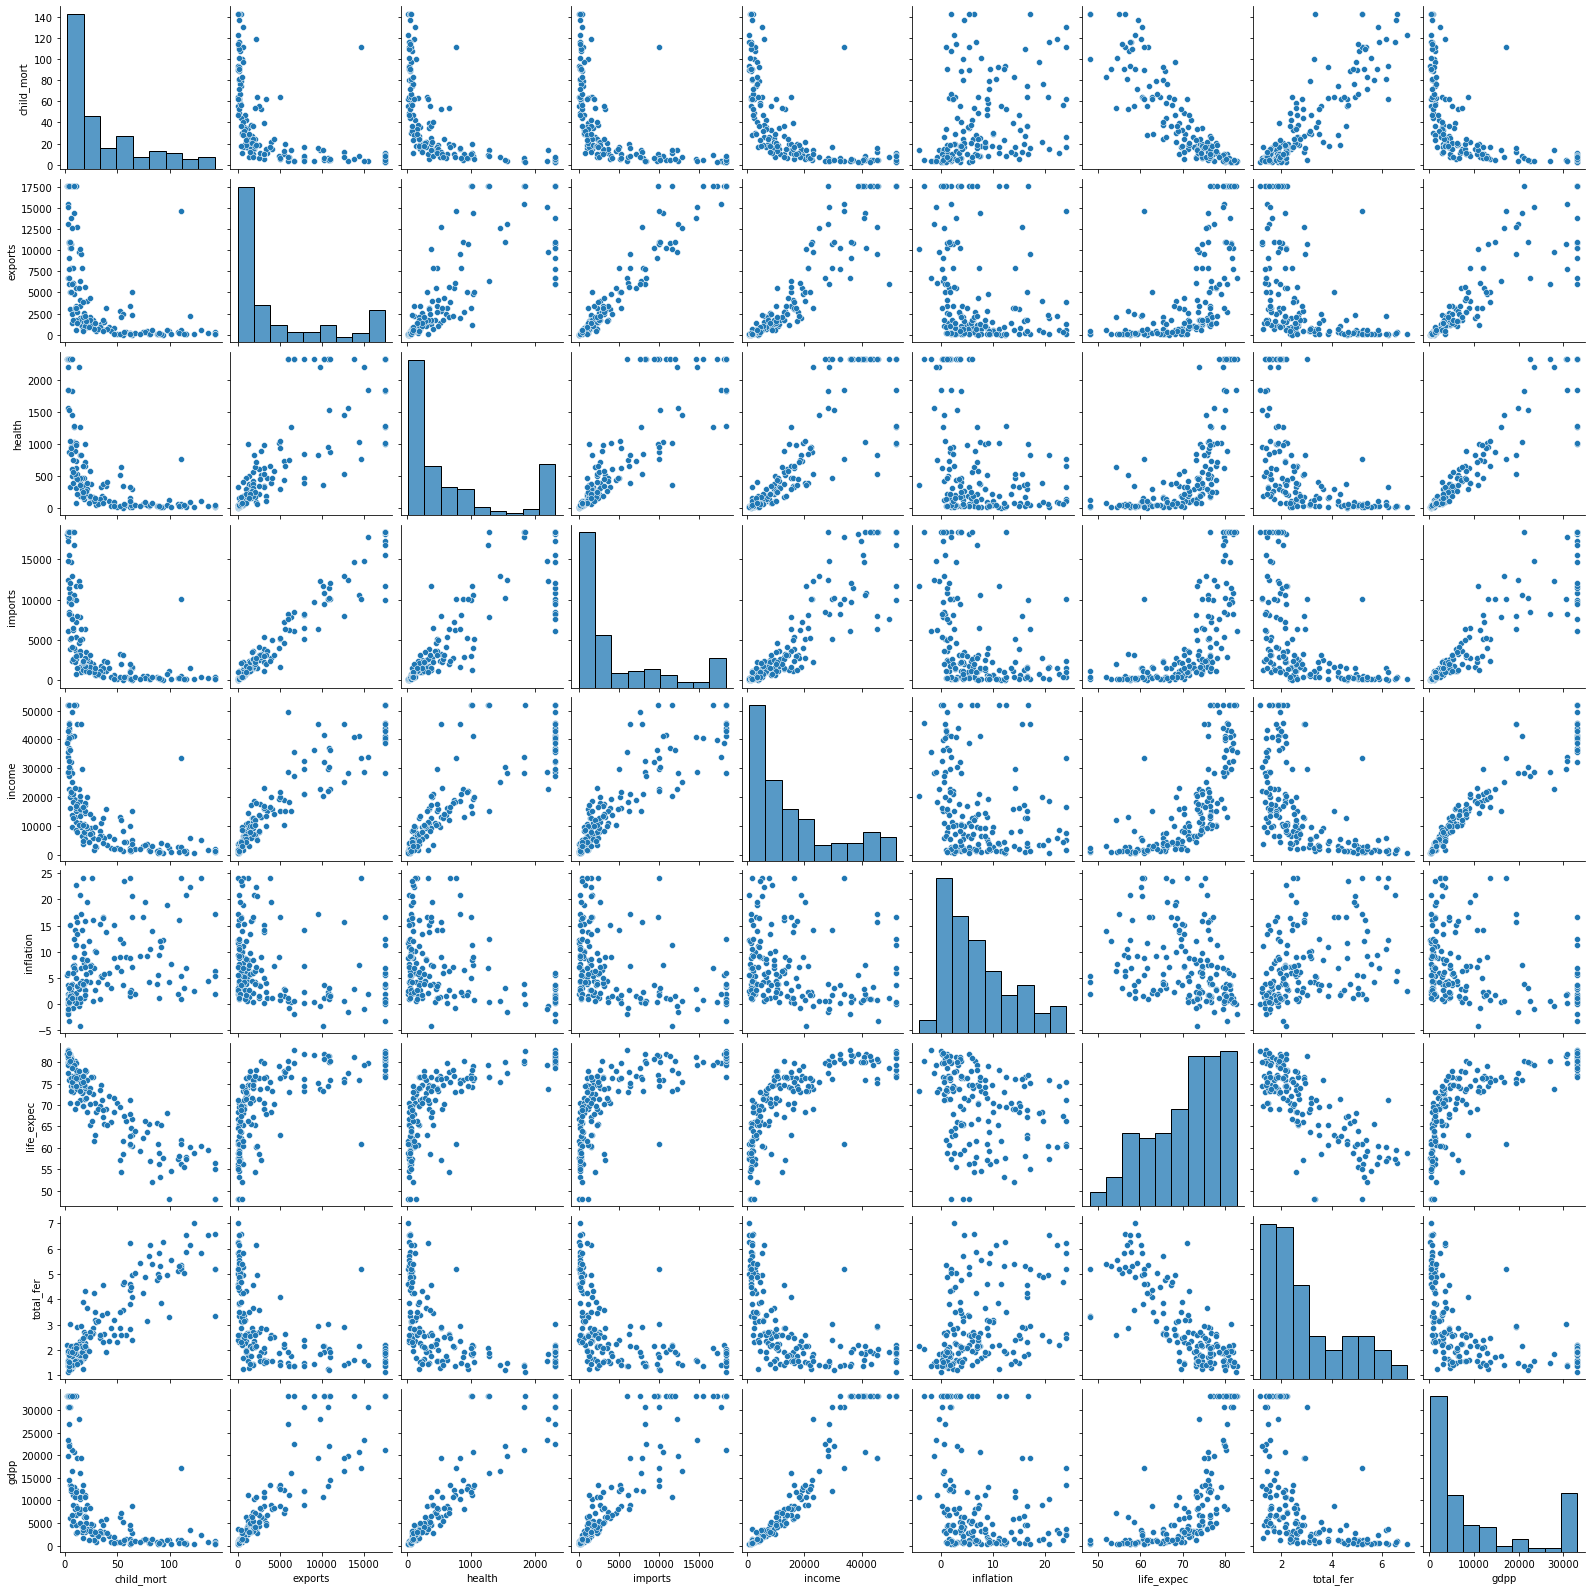

In [18]:
sns.pairplot(df)
plt.show()

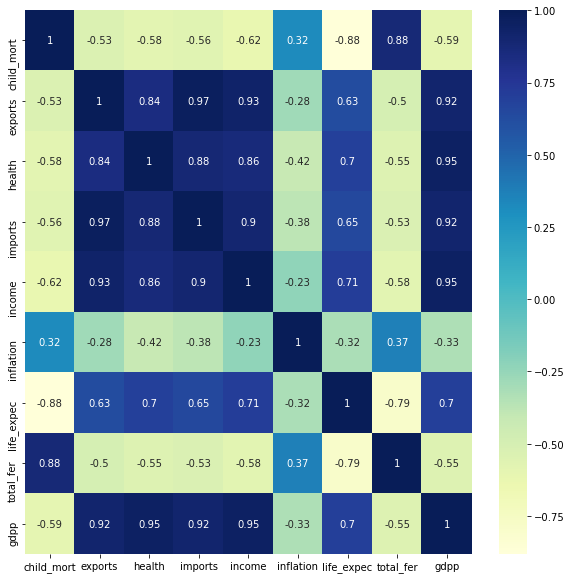

In [19]:
plt.figure(figsize = (10,10))  
sns.heatmap(df.corr(),annot = True,cmap="YlGnBu")
plt.show()

## Clustering

#### Hopkins Test

In [20]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
hopkins(df.drop('country', axis = 1))


0.8651733697180629

The obtained data is good for clustering

#### Scaling Data

In [22]:
df1 =df.drop('country',axis=1)

In [23]:
standard_scaler = StandardScaler()
df1 = standard_scaler.fit_transform(df1)

### K-Means Clustering

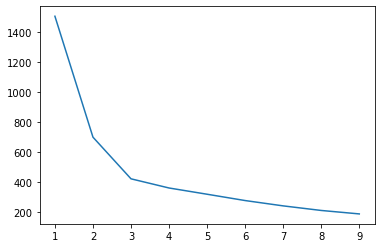

In [24]:
# Finding Optimal number of clusters.
# Elbow Curve
ssd = []
for k in list(range(1,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(df1)
    ssd.append([k, model.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1]);

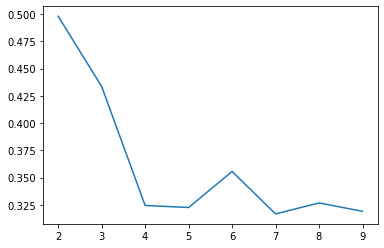

In [25]:
ss = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1]);

In [26]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.49089694803242895
For n_clusters=3, the silhouette score is 0.43360177139259876
For n_clusters=4, the silhouette score is 0.32436810285701795
For n_clusters=5, the silhouette score is 0.32513946562638196
For n_clusters=6, the silhouette score is 0.30609231429063594
For n_clusters=7, the silhouette score is 0.3195242628649288
For n_clusters=8, the silhouette score is 0.3248171244654303


#### Optimal Number of K =3

#### KMeans

In [28]:
kmeans = KMeans(n_clusters=3, max_iter=100 , random_state = 100)
kmeans.fit(df1)

KMeans(max_iter=100, n_clusters=3, random_state=100)

In [29]:
kmeans.labels_


array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [30]:
#keeping our original data safe
df_org = df.copy()

In [31]:
df_km = pd.concat([df, pd.Series(kmeans.labels_)], axis = 1)
df_km.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','cluster_id']
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [32]:
df_km['cluster_id'].value_counts()

2    78
1    48
0    41
Name: cluster_id, dtype: int64

### Visualization of KMeans Clustering

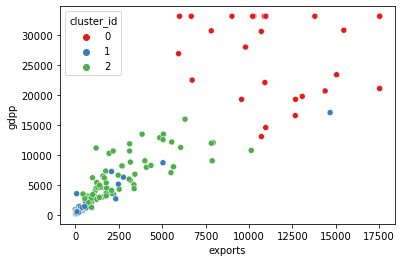

In [33]:
sns.scatterplot(x = 'exports', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

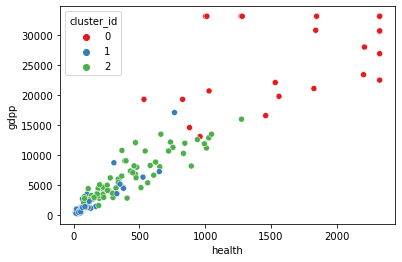

In [34]:
sns.scatterplot(x = 'health', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()


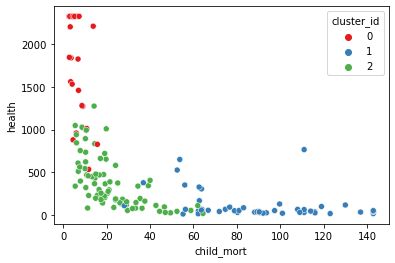

In [35]:
sns.scatterplot(x = 'child_mort', y = 'health', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

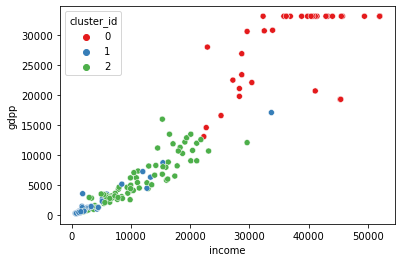

In [36]:
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

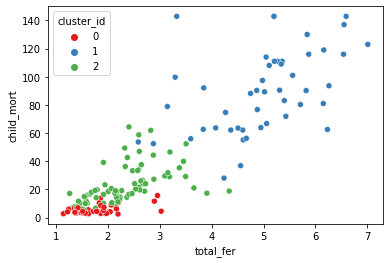

In [37]:
sns.scatterplot(x = 'total_fer', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

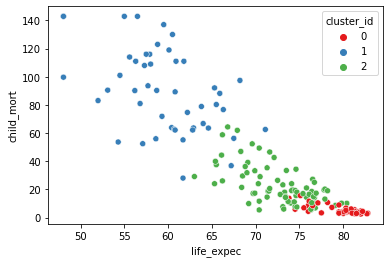

In [38]:
sns.scatterplot(x = 'life_expec', y = 'child_mort', hue ='cluster_id', legend = 'full', data = df_km, palette='Set1')
plt.show()

### KMeans Cluster Profiling

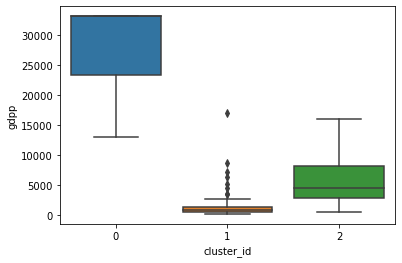

In [39]:
sns.boxplot(data=df_km,x = 'cluster_id',y='gdpp')
plt.show()

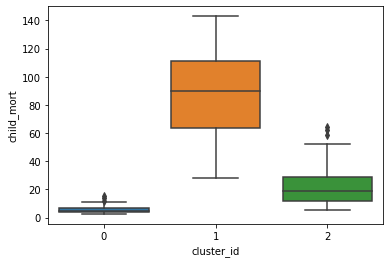

In [40]:
sns.boxplot(data=df_km,x = 'cluster_id',y='child_mort')
plt.show()

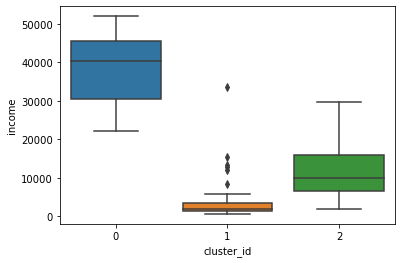

In [41]:
sns.boxplot(data=df_km,x = 'cluster_id',y='income')
plt.show()

#### Cluster id 1 has very low income and gdpp and very high child mortality rate.

In [44]:
#Finding the observations that belong to cluster id 0

df_km[df_km['cluster_id']==1]['country']

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

In [45]:
top_kmeans = df_km[df_km['cluster_id']==0].sort_values(by=["child_mort","gdpp","income"], ascending=[False, True,True])
top_kmeans = top_kmeans.reset_index().drop('index',axis=1)
top_kmeans.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Saudi Arabia,15.7,9572.80,827.97000,6369.0000,45400.0,17.200,75.1,2.96,19300.0,0
1,Bahamas,13.8,9800.00,2209.20000,12236.0000,22900.0,-0.393,73.8,1.86,28000.0,0
2,Oman,11.7,12680.10,534.61000,7951.6000,45300.0,15.600,76.1,2.90,19300.0,0
3,Kuwait,10.8,17524.29,1012.55000,11704.0000,51967.5,11.200,78.2,2.21,33130.0,0
4,Brunei,10.5,17524.29,1002.52000,9884.0000,51967.5,16.700,77.1,1.84,33130.0,0
5,Qatar,9.0,17524.29,1272.43000,16731.4000,51967.5,6.980,79.5,2.07,33130.0,0
6,Bahrain,8.6,14386.50,1028.79000,10536.3000,41100.0,7.440,76.0,2.16,20700.0,0
7,United Arab Emirates,8.6,17524.29,1281.00000,18338.6775,51967.5,12.500,76.5,1.87,33130.0,0
8,United States,7.3,6001.60,2324.54675,7647.2000,49400.0,1.220,78.7,1.93,33130.0,0
9,Slovak Republic,7.0,12665.80,1459.14000,12914.8000,25200.0,0.485,75.5,1.43,16600.0,0


In [46]:
top_10 = top_kmeans.iloc[:10]
top_10['country'].reset_index().drop('index',axis=1)

,country
0,Saudi Arabia
1,Bahamas
2,Oman
3,Kuwait
4,Brunei
5,Qatar
6,Bahrain
7,United Arab Emirates
8,United States
9,Slovak Republic


### Top 10 countries obtained from K-Means Model are:
    Saudi Arabia
    Bahamas
    Oman
    Kuwait
    Brunei
    Qatar
    Bahrain
    United Arab Emirates
    United states
    Slovak Republic

### Heirarichal Clustering

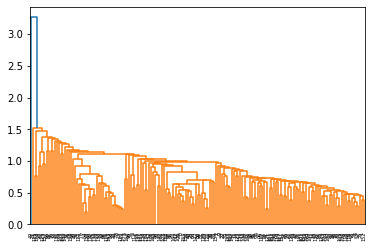

In [47]:
mergings_single = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()

Clusters formed are not so clearly visible

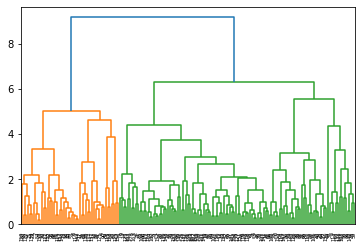

In [48]:
mergings_complete = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

Single Linkage is not clear so we will opt for Complete linkage model.`

#### There seem to be 3 clusters of hierarchical clustering

In [49]:
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0,
       0, 2, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [50]:
df_hm = pd.concat([df, pd.Series(cluster_labels)], axis = 1)
df_hm.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','cluster_labels']
df_hm.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [51]:
df_hm['cluster_labels'].value_counts()


1    75
2    49
0    43
Name: cluster_labels, dtype: int64

### Visualization by Hierarchical Clustering

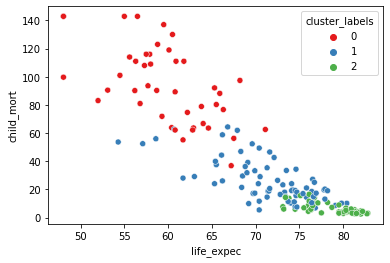

In [52]:
sns.scatterplot(x = 'life_expec', y = 'child_mort', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

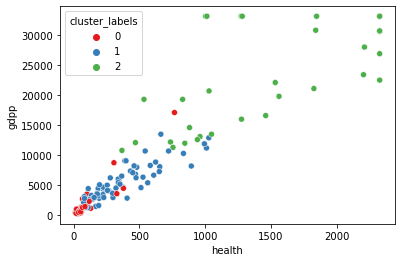

In [53]:
sns.scatterplot(x = 'health', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

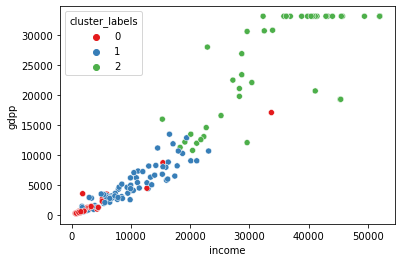

In [54]:
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()


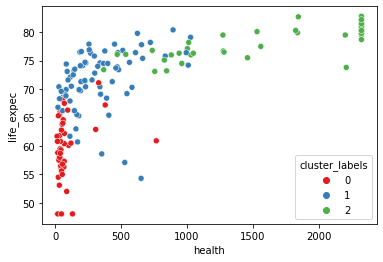

In [55]:
sns.scatterplot(x = 'health', y = 'life_expec', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

### Cluster Profiling

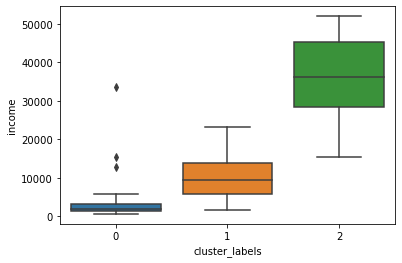

In [56]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='income')
plt.show()

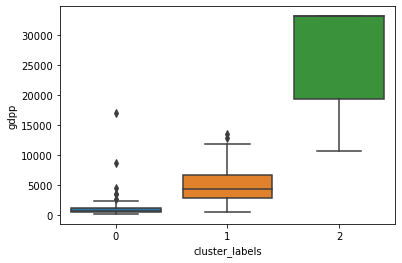

In [57]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='gdpp')
plt.show()

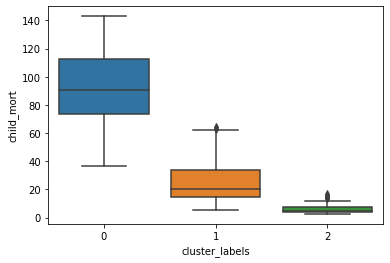

In [58]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='child_mort')
plt.show()


Cluster 0 have low income , low gdpp and high child_mort rate.



#### Observations belonging to Cluster 0

In [60]:
df_hm[df_hm['cluster_labels']==0]['country']


0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
112                       Niger
113     

In [61]:
top_h = df_hm[df_hm['cluster_labels']==0].sort_values(by=["child_mort","gdpp","income"], ascending=[False, True,True]) 
top_h = top_h.reset_index().drop('index',1)
top_h.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Sierra Leone,142.875,67.032,52.2690,137.655,1220.0,17.20,55.00,5.2000,399.0,0
1,Central African Republic,142.875,52.628,17.7508,118.190,888.0,2.01,48.05,5.2100,446.0,0
2,Haiti,142.875,101.286,45.7442,428.314,1500.0,5.45,48.05,3.3300,662.0,0
3,Chad,142.875,330.096,40.6341,390.195,1930.0,6.39,56.50,6.5900,897.0,0
4,Mali,137.000,161.424,35.2584,248.508,1870.0,4.37,59.50,6.5500,708.0,0
5,Nigeria,130.000,589.490,118.1310,405.420,5150.0,24.16,60.50,5.8400,2330.0,0
6,Niger,123.000,77.256,17.9568,170.868,814.0,2.55,58.80,7.0075,348.0,0
7,Angola,119.000,2199.190,100.6050,1514.370,5900.0,22.40,60.10,6.1600,3530.0,0
8,"Congo, Dem. Rep.",116.000,137.274,26.4194,165.664,609.0,20.80,57.50,6.5400,334.0,0
9,Burkina Faso,116.000,110.400,38.7550,170.200,1430.0,6.81,57.90,5.8700,575.0,0


In [62]:
top_10 = top_h.iloc[:10]
top_10['country'].reset_index().drop('index',axis=1)

,country
0,Sierra Leone
1,Central African Republic
2,Haiti
3,Chad
4,Mali
5,Nigeria
6,Niger
7,Angola
8,"Congo, Dem. Rep."
9,Burkina Faso


### Top 10 Countries obtained from Hierarchical Models are.
    Sierra Leone
    Central African Republic
    Haiti
    Chad
    Mali
    Nigeria
    Niger
    Angola
    Congo, Dem. Rep.
    Burkina Faso